#仕様
+ 実装はPytorch
+ Colaboratory単体（GPU）で動作可能（gdriveを経由する必要はない）
+ ESC-50をtrain(80%)とval(20%)に分け学習（cross validationではない）
+ DAは時間方向の移動、ホワイトノイズ、（ストレッチは処理時間が長いのでコメントアウト）
+ melspecを3CHにして、それを224X224にリサイズ
+ MobileNetv2に投げ学習

|初期値|精度|
|---|---|
|ImageNet学習済|62.17%|
|ランダム|43.36%|

（参考資料）
+ https://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
+ https://qiita.com/cvusk/items/61cdbce80785eaf28349#augmentation
+ https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast

#data load

In [1]:
!git clone https://github.com/karolpiczak/ESC-50

Cloning into 'ESC-50'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4136 (delta 1), reused 0 (delta 0), pack-reused 4129
Receiving objects: 100% (4136/4136), 878.77 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (244/244), done.
Checking out files: 100% (2011/2011), done.


In [2]:
!pip install soundfile

In [3]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import soundfile as sf
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import cv2

# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    #x, fs = sf.read(file_path)
    return x, fs

# define directories
base_dir = "ESC-50/"
meta_file = os.path.join(base_dir, "meta/esc50.csv")
audio_dir = os.path.join(base_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

# get training dataset and target dataset
x_list = list(meta_data.loc[:,"filename"])
y_list = list(meta_data.loc[:, "target"])

#分割

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = [], [], [], []

for i in range(len(x_list)):
    if np.random.rand() > 0.2:# 80%
        x_train.append(x_list[i])
        y_train.append(y_list[i])
    else:
        x_test.append(x_list[i])
        y_test.append(y_list[i])

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

1548 1548
452 452


#DA

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

class SpecTransform():
    def __init__(self, resize=224):
        self.resize = resize

    def __call__(self, wave, phase='train'):
        now = time.time()
        wave = load_wave_data(audio_dir, wave)[0]
        #print("read ", time.time() - now)
        if phase == "train" or phase == "try":
              wave = self.add_white_noise(wave)
              #print("wn   ", time.time() - now)
              wave = self.shift_sound(wave)
              #print("shift", time.time() - now)
              #wave = self.stretch_sound(wave)
              #print("st   ", time.time() - now)
              melspec = self.to_melspec(wave)
              #print("mel  ", time.time() - now)
        else:
              melspec = self.to_melspec(wave)
        melspec = self.mono_to_color(melspec)
        melspec = np.clip(melspec, 0, 1)
        melspec = cv2.resize(melspec, (self.resize, self.resize))
        if phase == "try":
            return melspec, wave
        else:
            return melspec

    def to_melspec(self, y, sr=44100, n_mels=128, fmin=20, fmax=16000):
        melspec = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec).astype(np.float32)
        return melspec

    def mono_to_color(self, X):
        return np.stack([X, X, X], axis=-1)

    # data augmentation: add white noise
    def add_white_noise(self, x, rate=0.001):
        return x + rate*np.random.randn(len(x))

    # data augmentation: shift sound in timeframe
    def shift_sound(self, x, rate=2):
        return np.roll(x, int(len(x)//(rate + np.random.randn())))

    # data augmentation: stretch sound
    def stretch_sound(self, x, rate=1.1):
        input_length = len(x)
        x = librosa.effects.time_stretch(x, rate + 0.1*np.random.randn())
        if len(x)>input_length:
            return x[:input_length]
        else:
            return np.pad(x, (0, max(0, input_length - len(x))), "constant")

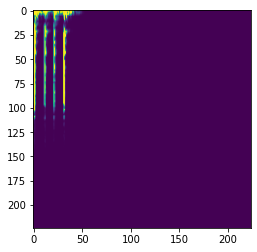

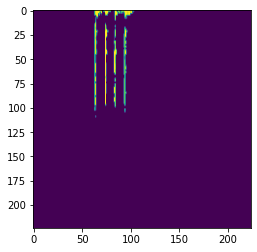

In [7]:
import IPython.display as ipd
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果が変わる

# 1. 音の読み込み
wav_file_path = '1-103999-A-30.wav'
wave, _ = load_wave_data(audio_dir, wav_file_path)
melspec = librosa.feature.melspectrogram(wave, sr=44100, n_mels=128, fmin=20, fmax=16000)
melspec_transformed = np.clip(melspec, 0, 1)
melspec_transformed = cv2.resize(melspec_transformed, (224,224))
#img = Image.open(image_file_path)   # [高さ][幅][色RGB]
ipd.display(ipd.Audio(wave, rate=44100))

# 2. 元のmelspecの表示
plt.imshow(melspec_transformed)
plt.show()

# 3. 前処理と処理済みmelspcecの表示
transform = SpecTransform()
melspec, wave = transform(wav_file_path, phase="try")  # torch.Size([3, 224, 224])

plt.imshow(melspec[:,:,0])
plt.show()
ipd.display(ipd.Audio(wave, rate=44100))

#DataSet

In [8]:
class Dataset(data.Dataset):
    def __init__(self, x_list, y_list, phase='train'):
        self.file_list = x_list  # ファイルパスのリスト
        self.y_list = y_list  # ファイルパスのリスト
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        # index番目の画像をロード
        label = self.y_list[index]
        wav_path = self.file_list[index]

        # 画像の前処理を実施
        melspec_transformed = transform(wav_path, self.phase)  # torch.Size([3, 224, 224])
        melspec_transformed = np.moveaxis(melspec_transformed, 2, 0)

        return melspec_transformed, label

# 実行
train_dataset = Dataset(x_list=x_train, y_list=y_train ,phase='train')
val_dataset = Dataset(x_list=x_test, y_list=y_test, phase='val')

# 動作確認
index = 50
print(train_dataset.__getitem__(index)[0].shape)
print(train_dataset.__getitem__(index)[1])

(3, 224, 224)
40


In [9]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([26, 22,  7, 23,  7, 17, 45, 34,  5, 25, 43, 15, 21,  3, 46, 14, 39, 10,
         6, 19, 34, 38, 21,  2, 41, 20, 45, 44, 13, 39, 22, 20])


#学習

In [10]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, scheduler,  num_epochs):
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            #if (epoch == 0) and (phase == 'train'):
            #    continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()
                inputs = inputs.cuda()##
                labels = labels.cuda()##

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
            
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

#実行

##転移学習

In [13]:
# 学習済みのMobileNetV2モデルをロード
use_pretrained = True  # 学習済みのパラメータを使用
model = models.mobilenet_v2(pretrained=use_pretrained)

del model.classifier

# MobileNetV2の最後の出力層の出力ユニットを50個にする
model.classifier = nn.Sequential(
        nn.Linear(1280, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 50))

# 訓練モードに設定
model.train()
device = torch.device("cuda")
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

"""# 学習させるパラメータ名
update_param_names = ["classifier.0.weight", "classifier.0.bias",
                      "classifier.3.weight", "classifier.3.bias",
                      "classifier.6.weight", "classifier.6.bias"]##

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
"""

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    param.requires_grad = True
    params_to_update.append(param)

# params_to_updateの中身を確認
#print("-----------")
#print(params_to_update)

# 最適化手法の設定
optimizer = optim.Adam(params=params_to_update, lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)

In [ ]:
# 学習・検証を実行する
num_epochs=50
train_model(model, dataloaders_dict, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/50
-------------



train Loss: 3.6714 Acc: 0.0601



val Loss: 3.2829 Acc: 0.1460
Epoch 2/50
-------------



train Loss: 3.0069 Acc: 0.1693



val Loss: 2.9805 Acc: 0.1726
Epoch 3/50
-------------



train Loss: 2.6295 Acc: 0.2125



val Loss: 2.7129 Acc: 0.2146
Epoch 4/50
-------------



train Loss: 2.3536 Acc: 0.2713



val Loss: 2.2385 Acc: 0.3385
Epoch 5/50
-------------



train Loss: 2.2201 Acc: 0.3314



val Loss: 3.6355 Acc: 0.1482
Epoch 6/50
-------------



train Loss: 2.0886 Acc: 0.3469



val Loss: 2.1703 Acc: 0.3230
Epoch 7/50
-------------



train Loss: 1.8518 Acc: 0.4057



val Loss: 2.4998 Acc: 0.2876
Epoch 8/50
-------------



train Loss: 1.9060 Acc: 0.3811



val Loss: 2.2271 Acc: 0.3451
Epoch 9/50
-------------



train Loss: 1.7905 Acc: 0.4264



val Loss: 2.0195 Acc: 0.4159
Epoch 10/50
-------------


##ランダム初期値

In [ ]:
# 学習済みのMobileNetV2モデルをロード
use_pretrained = False  # 学習済みのパラメータを使用
model = models.mobilenet_v2(pretrained=use_pretrained)

del model.classifier

# MobileNetV2の最後の出力層の出力ユニットを50個にする
model.classifier = nn.Sequential(
        nn.Linear(1280, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 50))

# 訓練モードに設定
model.train()
device = torch.device("cuda")
model.to(device)

In [ ]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

"""# 学習させるパラメータ名
update_param_names = ["classifier.0.weight", "classifier.0.bias",
                      "classifier.3.weight", "classifier.3.bias",
                      "classifier.6.weight", "classifier.6.bias"]##

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
"""

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    param.requires_grad = True
    params_to_update.append(param)

# params_to_updateの中身を確認
#print("-----------")
#print(params_to_update)

# 最適化手法の設定
optimizer = optim.Adam(params=params_to_update, lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)

In [ ]:
# 学習・検証を実行する
num_epochs=50
train_model(model, dataloaders_dict, criterion, optimizer, scheduler, num_epochs=num_epochs)